<a href="https://colab.research.google.com/github/kwanderer/MachineLearning/blob/main/MD_LSTM_binary_step_200_files_50.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>



#Datu kopa

Datu kopas avots: https://www.kaggle.com/uysalserkan/fault-induction-motor-dataset

Darbā tiek izmantota indukcijas motora parametru datu bāze. Izmantotajā datu kopā ir dati, kas tika iegūti SpectraQuest aparatūras kļūdu simulatorā (Machinery Fault Simulator).

Katra mērījumu secība tika ģenerēta ar frekvenci 50 kHz 5 sekunžu laikā, kopā 250 000 mērījumi.

Dati ir apkopoti vairākos failos, dažādos darbības stāvokļos un to apjoms ir ļoti liels. Šajā darbā tika izmantota daļa(viena mērījumu secība) no motora normālas darbības datiem.


Dati ir apkopoti tabulā, kura satur 8 parametrus. Dati ir iedalīti sekojošās kolonas:

**tachometer** – tahometra signāls, kas ļauj novērtēt rotācijas frekvenci

**und-accelerometer-axial** - apakšā esošā gultņa akselerometrs (aksiālais virziens)

**und-accelerometer-radial** – apakšā esošā gultņa akselerometrs (radiālais virziens)

**und-accelerometer-tangential** - apakšā esošā gultņa akselerometrs (tangenciālais virziens)

**over-accelerometer-axial** - pārkares gultņa akselerometrs (aksiālais virziens)

**over-accelerometer-radial** – pārkares gultņa akselerometrs (radiālais  virziens)

**over-accelerometer-tangential**  - pārkares gultņa akselerometrs (tangenciālais virziens)

**microphone** – mikrofona vērtība


#Datu ielasīšana un satura vizualizācija

In [1]:
import keras
from keras.layers import LSTM, Dropout, Dense
import tensorflow as tf
import numpy as np
import pandas as pd

from sklearn import linear_model  #pip install sklearn - loti plasa masinapmacibas biblioteka
from sklearn.linear_model import LinearRegression  
import csv          #pip install csv - darbam ar CSV datu kopam
import requests     #pip install requests  - vienkarsakam darbam ar tiessaistes CSV datu kopam tiessaistes

import matplotlib
import matplotlib.pyplot as plt

import glob


In [2]:
from google.colab import drive
import os
drive.mount('/content/gdrive')
os.chdir("/content/gdrive/MyDrive/Colab Notebooks/data_binary/")

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [3]:
#extension = 'csv'
#all_filenames = [i for i in glob.glob('*.{}'.format(extension))]

In [4]:
#combine all files in the list
#combined_csv = pd.concat([pd.read_csv(f) for f in all_filenames ])
#export to csv
#combined_csv.to_csv( "binary_data_csv.csv", index=False, encoding='utf-8-sig')

In [5]:
data = pd.read_csv("binary_data_csv.csv")

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12500000 entries, 0 to 12499999
Data columns (total 9 columns):
 #   Column                         Dtype  
---  ------                         -----  
 0   tachometer                     float64
 1   und-accelerometer-axial        float64
 2   und-accelerometer-radial       float64
 3   und-accelerometer-tangential   float64
 4   over-accelerometer-axial       float64
 5   over-accelerometer-radial      float64
 6   over-accelerometer-tangential  float64
 7   microphone                     float64
 8   Class                          int64  
dtypes: float64(8), int64(1)
memory usage: 858.3 MB


In [7]:
rec_count = len(data)
rec_count

12500000

# Datu dalīšana mazākos gabalos

In [8]:
sequence_length = 200

In [9]:
def generate_data(X, y, sequence_length = 200, step = 200):
    X_local = []
    y_local = []
    for start in range(0, len(data) - sequence_length, step):
        end = start + sequence_length
        X_local.append(X[start:end])
        y_local.append(y[end-1])
    return np.array(X_local), np.array(y_local)

X_sequence, y = generate_data(data.loc[:, "tachometer":"microphone"].values, data.Class)

In [10]:
X_sequence.shape, y.shape

((62499, 200, 8), (62499,))

In [11]:
data = 0

# Random/Shuffle

In [12]:
shuffler = np.random.permutation(len(X_sequence))
X_sequence_shuffled = X_sequence[shuffler]
y_shuffled = y[shuffler]

# LSTM

In [13]:
import pandas as pd
import sklearn.metrics as metrique
from pandas import Series
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from matplotlib import pyplot
from sklearn.model_selection import train_test_split
import numpy as np
import tensorflow as tf
import sys
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report
import warnings
warnings.filterwarnings('ignore')
plt.style.use('ggplot')
import seaborn as sns 
%matplotlib inline
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report, confusion_matrix
from keras.models import Sequential
from keras.utils import np_utils
from keras.layers import LSTM, Dense, Embedding, Dropout,Input, Layer, Concatenate, Permute, Dot, Multiply, Flatten
from keras.layers import RepeatVector, Dense, Activation, Lambda
from keras.models import Sequential
from keras import backend as K, regularizers, Model, metrics
from keras.backend import cast

In [14]:
from tensorflow.keras import optimizers
sgd = optimizers.SGD(lr=0.0001, decay=1e-6, momentum=0.9, nesterov=True)
model = keras.Sequential()
model.add(LSTM(100, input_shape = (200, 8)))
model.add(Dropout(0.5))
model.add(Dense(1, activation="sigmoid"))

#model.compile(loss='mean_squared_error', optimizer=sgd)
model.compile(loss="binary_crossentropy"
              , metrics=[keras.metrics.binary_accuracy]
              , optimizer=sgd)

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 100)               43600     
                                                                 
 dropout (Dropout)           (None, 100)               0         
                                                                 
 dense (Dense)               (None, 1)                 101       
                                                                 
Total params: 43,701
Trainable params: 43,701
Non-trainable params: 0
_________________________________________________________________


In [15]:
training_size = int(len(X_sequence) * 0.8)
val_size = int(len(X_sequence) * 0.9)

In [16]:
X_train, y_train = X_sequence_shuffled[:training_size], y_shuffled[:training_size]
X_val, y_val = X_sequence_shuffled[training_size:val_size], y_shuffled[training_size:val_size]
X_test, y_test = X_sequence_shuffled[val_size:], y_shuffled[val_size:]

In [18]:
X_sequence = 0
y = 0

In [19]:
history = model.fit(X_train, y_train, batch_size=64, epochs=50, validation_data=(X_val, y_val))
model.save('AllDataModel_Binary_E50_B64.h5')

Epoch 1/50
782/782 [==============================] - 160s 201ms/step - loss: 0.6893 - binary_accuracy: 0.5368 - val_loss: 0.6784 - val_binary_accuracy: 0.5898
Epoch 2/50
782/782 [==============================] - 155s 198ms/step - loss: 0.6788 - binary_accuracy: 0.5721 - val_loss: 0.6724 - val_binary_accuracy: 0.5965
Epoch 3/50
782/782 [==============================] - 157s 201ms/step - loss: 0.6747 - binary_accuracy: 0.5845 - val_loss: 0.6693 - val_binary_accuracy: 0.5987
Epoch 4/50
782/782 [==============================] - 155s 199ms/step - loss: 0.6717 - binary_accuracy: 0.5895 - val_loss: 0.6671 - val_binary_accuracy: 0.5990
Epoch 5/50
782/782 [==============================] - 154s 198ms/step - loss: 0.6697 - binary_accuracy: 0.5901 - val_loss: 0.6650 - val_binary_accuracy: 0.5992
Epoch 6/50
782/782 [==============================] - 154s 197ms/step - loss: 0.6671 - binary_accuracy: 0.5916 - val_loss: 0.6629 - val_binary_accuracy: 0.5992
Epoch 7/50
782/782 [====================

In [20]:
model.evaluate(X_val, y_val)

196/196 [==============================] - 8s 41ms/step - loss: 0.1920 - binary_accuracy: 0.9307


[0.19200854003429413, 0.9307199716567993]

In [21]:
y_test_prob = model.predict(X_val, verbose=1)

196/196 [==============================] - 9s 41ms/step


In [22]:
y_test_pred = np.where(y_test_prob > 0.5, 1, 0)

In [23]:
from sklearn.metrics import confusion_matrix

In [24]:
confusion_matrix(y_val, y_test_pred)

array([[2425,   79],
       [ 354, 3392]])

Confusion matrix, without normalization
[[2425   79]
 [ 354 3392]]
Normalized confusion matrix
[[0.97 0.03]
 [0.09 0.91]]


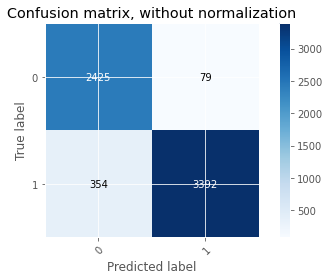

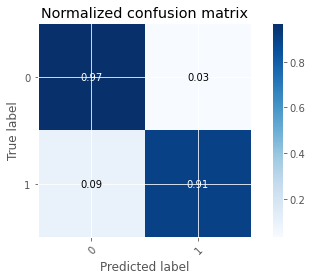

In [25]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn import svm, datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels

class_names = np.array(['0', '1'])

def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()

    return ax


np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plot_confusion_matrix(y_val, y_test_pred, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plot_confusion_matrix(y_val, y_test_pred, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

In [26]:
def plot_learningCurve(history, epoch):
  # Plot training & validation accuracy values
  epoch_range = range(1, epoch+1)
  plt.plot(epoch_range, history.history['binary_accuracy'])
  plt.plot(epoch_range, history.history['val_binary_accuracy'])
  plt.title('Model accuracy')
  plt.ylabel('Accuracy')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Val'], loc='upper left')
  plt.show()

  # Plot training & validation loss values
  plt.plot(epoch_range, history.history['loss'])
  plt.plot(epoch_range, history.history['val_loss'])
  plt.title('Model loss')
  plt.ylabel('Loss')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Val'], loc='upper left')
  plt.show()

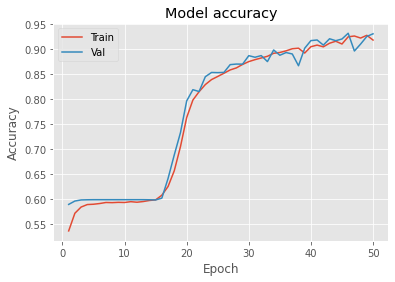

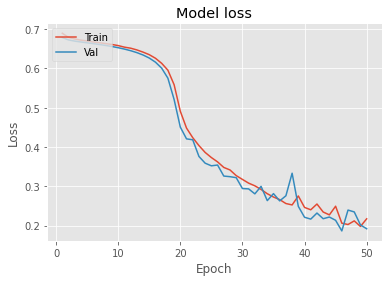

In [27]:
plot_learningCurve(history, 50)

In [28]:
##from keras.models import load_model
# Assuming your model includes instance of an "AttentionLayer" class
##uploadmodel = load_model('AllDataModel_E50_B64.h5')
#custom_ob = {'att_out': custom_layer.Attention,'AttLayer2': custom_layer.Attention}
#new_model = load_model('test.h5', custom_objects={'AttentionLayer': att_out})
#new_model = tf.keras.models.load_model('test.h5',custom_objects={'att_out': custom_layer.Attention})

# Show the model architecture
##uploadmodel.summary()
